In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from tqdm import tqdm
import descartes
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import repeat
import time
%matplotlib inline

Get 2010 block shapes from IPUMS dataset

In [3]:
SHAPE_FILEPATH = "data/block_2010_data/nhgis0005_shape/nhgis0005_shapefile_tl2010_"

def load_blocks(state, fips):
    """
    Loads a state's 2010 census blocks from IPUMS dataset.
    
    Parameters
    ----------
    state : string
        US state acronym (i.e 'CA') for requested block data.
    fips : string
        zero-padded state FIPS code for requested block data.
    
    Returns
    -------
    geopandas.GeoDataFrame
        block data of given state.
    """
    begin = time.time()
    blocks = gpd.read_file(f'{SHAPE_FILEPATH}{fips}_block_2010/{state}_block_2010.shp')
    print(f'{state} blocks loaded. Time: {np.round(time.time() - begin, 2)}s')
    return blocks

ca_blocks = load_blocks('CA', '060')
ga_blocks = load_blocks('GA', '130')
il_blocks = load_blocks('IL', '170')
md_blocks = load_blocks('MD', '240')
mi_blocks = load_blocks('MI', '260')
ny_blocks = load_blocks('NY', '360')
pa_blocks = load_blocks('PA', '420')

CA blocks loaded. Time: 34.1s
GA blocks loaded. Time: 13.9s
IL blocks loaded. Time: 20.31s
MD blocks loaded. Time: 7.13s
MI blocks loaded. Time: 14.91s
NY blocks loaded. Time: 16.52s
PA blocks loaded. Time: 20.07s


In [14]:
pa_blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GISJOIN,Shape_area,Shape_len,geometry
0,42,003,432400,3022,420034324003022,Block 3022,G5040,U,69697,U,S,0,64899,+40.4980142,-080.0731280,G42000304324003022,64898.940781,1197.587871,"POLYGON ((1332385.676 447813.179, 1332369.851 ..."
1,42,003,465600,1007,420034656001007,Block 1007,G5040,U,69697,U,S,24855,0,+40.4410750,-080.0779489,G42000304656001007,24855.476969,938.882067,"POLYGON ((1333022.815 441588.182, 1333014.015 ..."
2,42,003,465800,2011,420034658002011,Block 2011,G5040,U,69697,U,S,18215,0,+40.4345587,-080.0739816,G42000304658002011,18214.671399,653.514464,"POLYGON ((1333266.428 440937.730, 1333287.300 ..."
3,42,003,465800,2009,420034658002009,Block 2009,G5040,U,69697,U,S,17628,0,+40.4346776,-080.0718104,G42000304658002009,17628.221577,629.908582,"POLYGON ((1333577.414 440863.328, 1333568.989 ..."
4,42,003,465800,2016,420034658002016,Block 2016,G5040,U,69697,U,S,3994,0,+40.4338141,-080.0716646,G42000304658002016,3993.845855,263.373603,"POLYGON ((1333534.946 440802.744, 1333529.820 ..."


In [13]:
type(pa_blocks.crs)

pyproj.crs.crs.CRS

In [4]:
def adjust_data(blocks, target_crs, counties):
    """
    Removes irrelevant columns and puts data in redlining maps' CRS.
    
    Parameters
    ----------
    blocks : geopandas.GeoDataFrame
        (raw) block data for a given state.
    target_crs : pyproj.crs.crs.CRS
        Coordinate Reference System (CRS) to re-project data onto.
    counties : list
        list of county FIPS codes for relevant cities for analysis.
    
    Returns
    -------
    geopandas.GeoDataFrame
        cleaned block data for the state.
    """
    blocks = blocks.loc[blocks.COUNTYFP10.isin(counties)]
    blocks = blocks.to_crs(target_crs)
    return blocks.filter(['COUNTYFP10', 'GEOID10', 'geometry'])

In [5]:
# function to polygonize a geometry list
polygonize = lambda s: [shapely.ops.unary_union(x) if type(x) == shapely.geometry.multipolygon.MultiPolygon 
                           else x 
                           for x in s.values]

oakland_rl_map = gpd.read_file("data/redlining-maps/CAOakland1937.geojson")
oakland_rl_map['polygonized'] = polygonize(oakland_rl_map.geometry)

sd_rl_map = gpd.read_file("data/redlining-maps/CASanDiego1938.geojson")
sd_rl_map['polygonized'] = polygonize(sd_rl_map.geometry)

atlanta_rl_map = gpd.read_file("data/redlining-maps/GAAtlanta1938.geojson")
atlanta_rl_map['polygonized'] = polygonize(atlanta_rl_map.geometry)

chicago_rl_map = gpd.read_file("data/redlining-maps/ILChicago1940.geojson")
chicago_rl_map['polygonized'] = polygonize(chicago_rl_map.geometry)

baltimore_rl_map = gpd.read_file("data/redlining-maps/MDBaltimore1937.geojson")
baltimore_rl_map['polygonized'] = polygonize(baltimore_rl_map.geometry)

detroit_rl_map = gpd.read_file("data/redlining-maps/MIDetroit1939.geojson")
detroit_rl_map['polygonized'] = polygonize(detroit_rl_map.geometry)

bronx_rl_map = gpd.read_file("data/redlining-maps/NYBronx1938.geojson")
bronx_rl_map['polygonized'] = polygonize(bronx_rl_map.geometry)

brooklyn_rl_map = gpd.read_file("data/redlining-maps/NYBrooklyn1938.geojson")
brooklyn_rl_map['polygonized'] = polygonize(brooklyn_rl_map.geometry)

manhattan_rl_map = gpd.read_file("data/redlining-maps/NYManhattan1937.geojson")
manhattan_rl_map['polygonized'] = polygonize(manhattan_rl_map.geometry)

queens_rl_map = gpd.read_file("data/redlining-maps/NYQueens1938.geojson")
queens_rl_map['polygonized'] = polygonize(queens_rl_map.geometry)

philly_rl_map = gpd.read_file("data/redlining-maps/PAPhiladelphia1937.geojson")
philly_rl_map['polygonized'] = polygonize(philly_rl_map.geometry)

In [6]:
ca_filtered = adjust_data(ca_blocks, oakland_rl_map.crs, ['001', '073'])
ga_filtered = adjust_data(ga_blocks, atlanta_rl_map.crs, ['121', '089'])
il_filtered = adjust_data(il_blocks, chicago_rl_map.crs, ['031'])
md_filtered = adjust_data(md_blocks, baltimore_rl_map.crs, ['510'])
mi_filtered = adjust_data(mi_blocks, detroit_rl_map.crs, ['163'])
ny_filtered = adjust_data(ny_blocks, bronx_rl_map.crs, ['005', '047', '061', '081'])
pa_filtered = adjust_data(pa_blocks, philly_rl_map.crs, ['101'])

In [39]:
manhattan_rl_map

,name,holc_id,holc_grade,area_description_data,geometry,polygonized
0,None,A1,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.96737 40.75281, -73.96679 ...","POLYGON ((-73.96736799999999 40.752814, -73.96..."
1,None,A2,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.96812 40.76064, -73.97086 ...","POLYGON ((-73.968119 40.760642, -73.970862 40...."
2,None,A3,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.97323 40.76463, -73.97277 ...","POLYGON ((-73.973232 40.764628, -73.9727709999..."
3,None,A4,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.95940 40.76952, -73.96064 ...","POLYGON ((-73.959397 40.769516, -73.960638 40...."
4,None,A5,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.95940 40.76952, -73.96288 ...","POLYGON ((-73.959397 40.769516, -73.962878 40...."
5,None,A6,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.95597 40.78011, -73.95770 ...","POLYGON ((-73.955975 40.78011, -73.9577 40.777..."
6,None,A7,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.95456 40.78813, -73.95481 ...","POLYGON ((-73.954562 40.788129, -73.954808 40...."
7,None,A8,A,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.92923 40.86684, -73.92765 ...","POLYGON ((-73.929226 40.866845, -73.927651 40...."
8,None,B1,B,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.99770 40.72992, -73.99956 ...","POLYGON ((-73.997703 40.72992, -73.99955799999..."
9,None,B10,B,"{'0': 'New York City, N.Y.', '5': 'Main busine...","MULTIPOLYGON (((-73.92812 40.84768, -73.92969 ...","POLYGON ((-73.92811500000001 40.847683, -73.92..."


In [36]:
def area_overlap(a, b):
    """
    Determines what % of a polygon overlaps with another.
    
    Parameters
    ----------
    a : shapely.geometry.Polygon
        first polygon to check overlap of ("overlaid" on b).
    b : shapely.geometry.Polygon
        polygon to check a against.
    
    Returns
    -------
    float
        % of polygon A which lies within polygon B.
    """
    try:
        return a.intersection(b).area / a.area
    except: # case where polygon is self-wrapping or invalid, throw it out
        return 0

In [66]:
def generate_crosswalk(city_args):
    """
    Returns a crosswalk of 1940 tract_ids in each redlined district.
    
    Parameters
    ----------
    city_args : tuple
        all args needed for method:
        city_name : string
            city to analyze.
        city_fips : list
            county FIPS codes for counties within the city.
        rl_map : geopandas.GeoDataFrame
            redlining district data for the city.
        block_map : geopandas.GeoDataFrame
            2010 block data for the state the city is in.
    
    Returns
    -------
    pandas.DataFrame
        crosswalk between redlining districts and blocks, with the following format:
        index | holc_id_uq | block_id_2010
        ----------------------------------
        <int> | <string>   | <string>
    """
    # parse tuple
    city_name, city_fips, rl_map, block_map = city_args
    
    # filter state blocks to just the ones in the city we're interested in
    if (len(np.unique(block_map.COUNTYFP10.values)) > len(city_fips)):
        blocks = block_map.loc[block_map.COUNTYFP10.isin(city_fips)]
    else:
        blocks = block_map
    rl_geometries = rl_map.polygonized.values
    
    block_id_2010 = []
    holc_id_uq = []
    
    for i in blocks.index: # iterate through the 2010 blocks
        # for each 2010 block, see it's overlap with each holc_id
        overlaps = list(map(area_overlap, repeat(blocks.loc[i].geometry), rl_geometries))
        if sum(overlaps) > 0.5:
            # since some districts don't have an id, max_district_id is composed of the district's grade + 
            # the district's index in the rl_map
            max_district_id = f'{rl_map.loc[np.argmax(overlaps)].holc_grade}{np.argmax(overlaps)}'
            block_id_2010.append(blocks.loc[i].GEOID10)
            holc_id_uq.append(max_district_id)
    
    crosswalk = pd.DataFrame({'block_id_2010': block_id_2010, 'holc_id_uq': holc_id_uq})
    crosswalk.set_index('block_id_2010', inplace=True)
    
    # summarize
    districts_with_similarity = np.round(len(crosswalk.index) / len(blocks.index),3)
    print(f"For {city_name}, {districts_with_similarity * 100}% blocks were matched to a district.")
    return crosswalk

In [69]:
import concurrent.futures
crosswalk_args = [('Oakland', ['001'], oakland_rl_map, ca_filtered),
                 ('San Diego', ['073'], sd_rl_map, ca_filtered),
                 ('Atlanta', ['121', '089'], atlanta_rl_map, ga_filtered),
                 ('Chicago', ['031'], chicago_rl_map, il_filtered),
                 ('Baltimore', ['510'], baltimore_rl_map, md_filtered),
                 ('Detroit', ['163'], detroit_rl_map, mi_filtered),
                 ('Bronx', ['005'], bronx_rl_map, ny_filtered),
                 ('Brooklyn', ['047'], brooklyn_rl_map, ny_filtered),
                 ('Manhattan', ['061'], manhattan_rl_map, ny_filtered),
                 ('Queens', ['081'], queens_rl_map, ny_filtered),
                 ('Philadelphia', ['101'], philly_rl_map, pa_filtered)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    for city, crosswalk in zip(list(map(lambda x: x[0], crosswalk_args)), 
                               executor.map(generate_crosswalk, crosswalk_args)):
        crosswalk.to_csv(f'data/outputs/{city}_blocks_2010_crosswalk.csv')
        print(f'Crosswalk for {city} written.')


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.929578851378821 40.841566544049336 at -73.929578851378821 40.841566544049336
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.815089044911659 40.865243409937996 at -73.815089044911659 40.865243409937996
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.87393894879034 40.852875481504874 at -73.87393894879034 40.852875481504874
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.87393894879034 40.852875481504874 at -73.87393894879034 40.852875481504874
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.87393894879034 40.852875481504874 at -73.87393894879034 40.852875481504874
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -76.660169018241319 39.284817096925842 at -76.660169018241319 39.284817096925842
TopologyExceptio

For Manhattan, 61.9% blocks were matched to a district.
For Bronx, 81.89999999999999% blocks were matched to a district.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.07605607551864 32.764750981277203 at -117.07605607551864 32.764750981277203
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.07605607551864 32.764750981277203 at -117.07605607551864 32.764750981277203
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.965089990413105 40.661217563385577 at -73.965089990413105 40.661217563385577
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.965089990413105 40.661217563385577 at -73.965089990413105 40.661217563385577
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.965089990413105 40.661217563385577 at -73.965089990413105 40.661217563385577
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.22905278546973 32.745671344034143 at -117.22905278546973 32.745671344034143
TopologyEx

For Brooklyn, 82.1% blocks were matched to a district.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -84.263299473116419 33.780029741909438 at -84.263299473116419 33.780029741909438
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.10926113150578 32.719141084913524 at -117.10926113150578 32.719141084913524


For Baltimore, 66.9% blocks were matched to a district.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.12098112179832 32.714458112052462 at -117.12098112179832 32.714458112052462
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.05716410396478 32.770878932359032 at -117.05716410396478 32.770878932359032
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -84.436229077659945 33.764616258411223 at -84.436229077659945 33.764616258411223
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -75.133030588286005 40.041871523540117 at -75.133030588286005 40.041871523540117
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -75.133030588286005 40.041871523540117 at -75.133030588286005 40.041871523540117
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -75.133030588286005 40.041871523540117 at -75.133030588286005 40.041871523540117
TopologyEx

For Philadelphia, 77.3% blocks were matched to a district.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -73.871545035995737 40.730855323697398 at -73.871545035995737 40.730855323697398
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -83.29346281046044 42.312006140924183 at -83.29346281046044 42.312006140924183
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -84.395517271189405 33.716166336171078 at -84.395517271189405 33.716166336171078
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -84.395517271189405 33.716166336171078 at -84.395517271189405 33.716166336171078
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.1582399969095 32.729298191338771 at -117.1582399969095 32.729298191338771
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -84.447483175397849 33.807877248095586 at -84.447483175397849 33.807877248095586
TopologyExcept

For Atlanta, 17.0% blocks were matched to a district.
For Queens, 69.6% blocks were matched to a district.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.26928652648084 32.841247185846719 at -117.26928652648084 32.841247185846719
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.26928652648084 32.841247185846719 at -117.26928652648084 32.841247185846719
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.26928652648084 32.841247185846719 at -117.26928652648084 32.841247185846719
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.26928652648084 32.841247185846719 at -117.26928652648084 32.841247185846719
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.26928652648084 32.841247185846719 at -117.26928652648084 32.841247185846719
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -117.26928652648084 32.841247185846719 at -117.26928652648084 32.841247185846719
TopologyEx

For Oakland, 31.3% blocks were matched to a district.
Crosswalk for Oakland written.
For San Diego, 14.799999999999999% blocks were matched to a district.
Crosswalk for San Diego written.
Crosswalk for Atlanta written.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -83.232969724166367 42.286884080825452 at -83.232969724166367 42.286884080825452


For Detroit, 54.6% blocks were matched to a district.


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -87.712597596089182 41.942247050256107 at -87.712597596089182 41.942247050256107


For Chicago, 52.7% blocks were matched to a district.
Crosswalk for Chicago written.
Crosswalk for Baltimore written.
Crosswalk for Detroit written.
Crosswalk for Bronx written.
Crosswalk for Brooklyn written.
Crosswalk for Manhattan written.
Crosswalk for Queens written.
Crosswalk for Philadelphia written.


In [7]:
sd_crosswalk = pd.read_csv('data/outputs/San Diego_blocks_2010_crosswalk.csv', 
                           dtype={'block_id_uq':str})
sd_crosswalk['block_id_2010'] = list(map(lambda x: f'0{x}', sd_crosswalk.block_id_2010))
sd_crosswalk.set_index('block_id_2010', inplace=True)
sd_crosswalk

,holc_id_uq
block_id_2010,
060730076004019,C52
060730007002017,B20
060730079102025,C48
060730042002046,C41
060730031111001,D60
...,...
060730016003000,C39
060730076007008,C52
060730108001006,B18


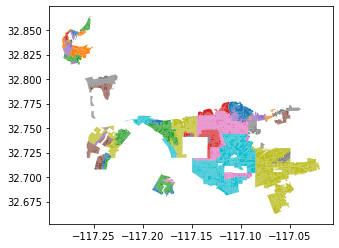

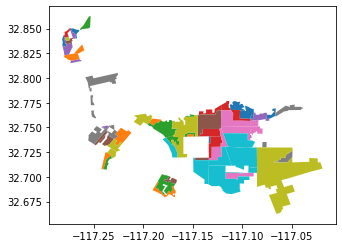

In [12]:
sd_full = ca_filtered.set_index('GEOID10').join(sd_crosswalk, how='outer').dropna()
sd_full.plot(column='holc_id_uq')
sd_rl_map.plot(column='holc_id')